<a href="https://colab.research.google.com/github/vikashnitk/disaster-tweet-classification-NLP/blob/main/Disaster_Tweets_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

plt.style.use('ggplot')

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from tensorflow.keras.optimizers import Adam

# Download Data

In [4]:
tweet = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/twitter-disaster-prediction-dataset/master/train.csv')

In [5]:
tweet.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
tweet.shape

(7613, 5)

In [7]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


# Exploratory Data Analysis

### Target Class Distribution

In [8]:
plt.rcParams['figure.figsize'] = [8,4]
plt.rcParams['figure.dpi'] = 80

NameError: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Real or Not Real Disaster Tweet')

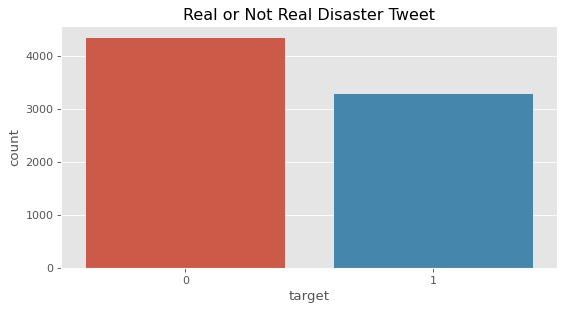

In [ ]:
sns.countplot('target', data=tweet)
plt.title('Real or Not Real Disaster Tweet')

In [ ]:
tweet['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

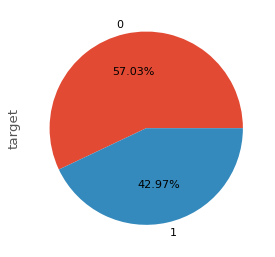

In [ ]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%')

### Number of Characters Distribution in Tweets

In [6]:
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git

  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-608a0qfx
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-608a0qfx
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11759 sha256=1a0ef471891ec550303c64559f8238839fcf112e409eca140d50dc1a73c597be
  Stored in directory: /tmp/pip-ephem-wheel-cache-zzcko9hm/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie


In [7]:
import preprocess_kgptalkie as kgp

In [8]:
tweet = kgp.get_basic_features(tweet)

In [9]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,72,16,4.500000,6,2,0,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


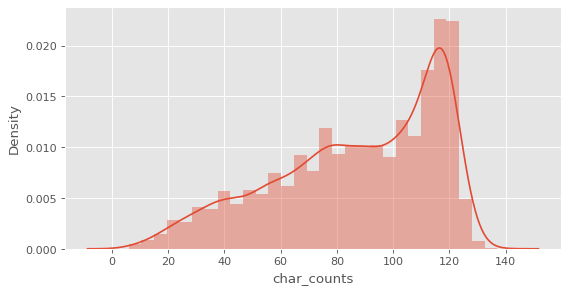

In [ ]:
sns.distplot(tweet['char_counts'])

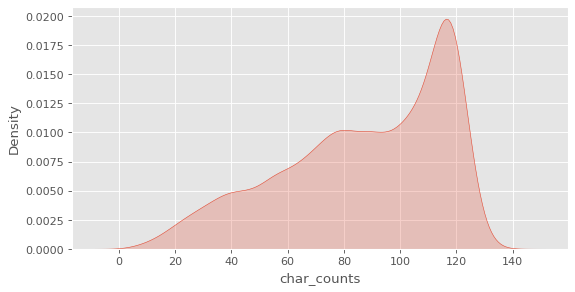

In [ ]:
sns.kdeplot(tweet['char_counts'], shade=True)

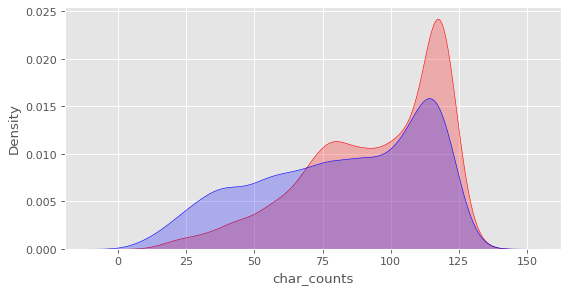

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], shade=True, color='blue')

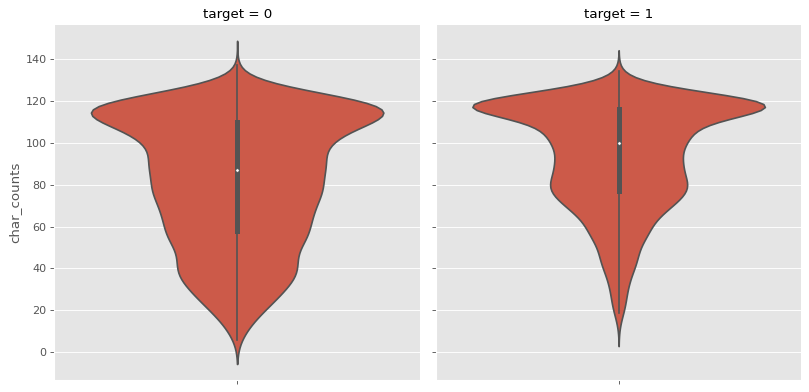

In [ ]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target')

### Number of Words, Average Words Length, and Stop words Distribution in Tweets

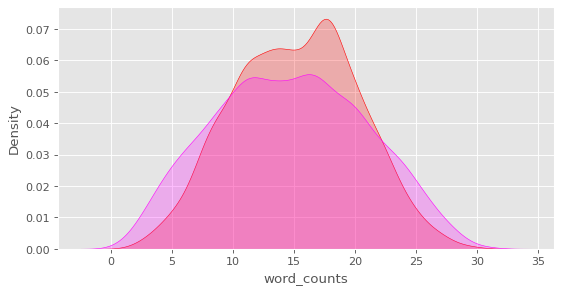

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], shade=True, color='magenta')


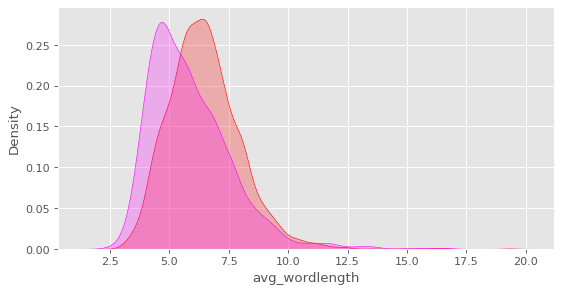

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], shade=True, color='magenta')


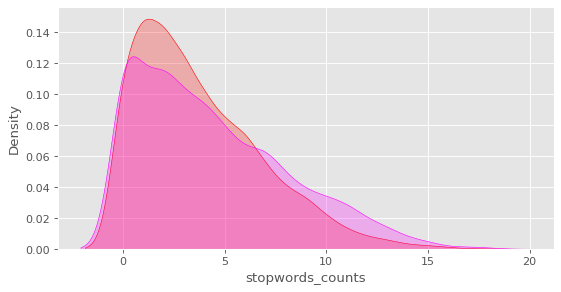

In [ ]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], shade=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], shade=True, color='magenta')


In [ ]:
tweet.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'char_counts',
       'word_counts', 'avg_wordlength', 'stopwords_counts', 'hashtag_counts',
       'mentions_counts', 'digits_counts', 'uppercase_counts'],
      dtype='object')

### Most and Least Common Words

In [ ]:
freqs = kgp.get_word_freqs(tweet, 'text')

In [ ]:
top20 = freqs[:20]

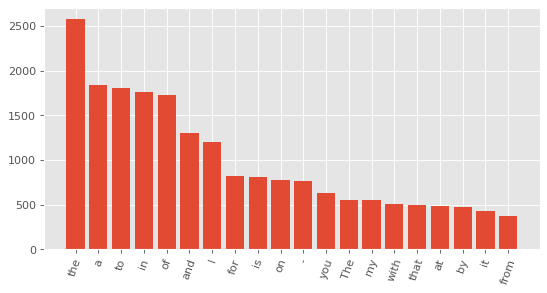

In [ ]:
plt.bar(top20.index, top20.values)
plt.xticks(rotation=70)
plt.show()

In [ ]:
least20 = freqs[-20:]
least20

@NigelTanner1             1
leak                      1
http://t.co/pc7S8NxJ6Q    1
#SportingGoods            1
http://t.co/v9ftYB30EI    1
wildfire...               1
blessed                   1
Fir                       1
pre-dynastic              1
smoke.                    1
piss                      1
#Airplane                 1
Value.                    1
#Columbus                 1
school's                  1
unfair                    1
http://t.co/q8n5Tn8WME    1
pigeon                    1
AUDIENCE:                 1
shops                     1
dtype: int64

In [ ]:
bigram = kgp.get_ngram(tweet, 'text', ngram_range=2)

In [ ]:
bigram[-20:]

[('00end date', 19),
 ('0000 utc', 18),
 ('000 riot', 17),
 ('000 people', 16),
 ('000 gems', 15),
 ('00 white', 14),
 ('00 tonight', 13),
 ('00 to', 12),
 ('00 thursday', 11),
 ('00 thread', 10),
 ('00 pm', 9),
 ('00 in', 8),
 ('00 http', 7),
 ('00 hiroshima', 6),
 ('00 bestseller', 5),
 ('00 at', 4),
 ('00 am', 3),
 ('00 52', 2),
 ('00 25', 1),
 ('00 11', 0)]

### One-Shot Data Cleaning

In [13]:
def get_clean(x):
    x = str(x).lower().replace('\\', ' ').replace('_', ' ').replace('.', ' ')
    x = kgp.cont_exp(x)
    x = kgp.remove_emails(x)
    x = kgp.remove_urls(x)
    x = kgp.remove_html_tags(x)
    x = kgp.remove_rt(x)
    x = kgp.remove_accented_chars(x)
    x = kgp.remove_special_chars(x)
    x = kgp.remove_dups_char(x)
    return x

In [14]:
tweet['text'] = tweet['text'].apply(lambda x: get_clean(x))

In [15]:
tweet.head()['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

In [ ]:
# kgp.get_ngram(tweet, 'text', ngram_range=2)

### Disaster Words Visualization with Word Cloud



In [ ]:
real = kgp.get_word_freqs(tweet[tweet['target']==1], 'text')
real = ' '.join(real.index)
real

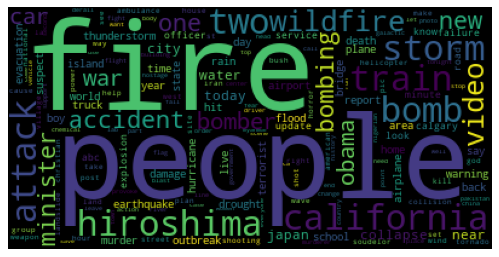

In [ ]:
word_cloud = WordCloud(max_font_size=100).generate(real)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

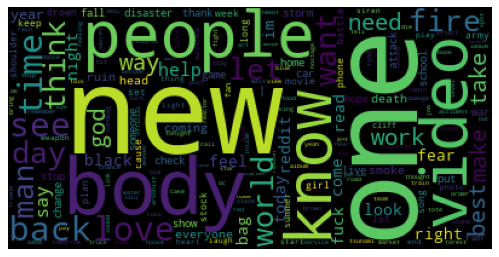

In [ ]:
# not real plot

nreal = kgp.get_word_freqs(tweet[tweet['target']==0], 'text')
nreal = ' '.join(nreal.index)
word_cloud = WordCloud(max_font_size=100).generate(nreal)
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Classification with TFIDF and SVM


In [ ]:
text = tweet['text']
y = tweet['target']

In [ ]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text)

In [ ]:
X.shape

(7613, 22545)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
def run_SVM(clf, X_train, X_test, y_train, y_test):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  print()
  print('Classification Report')
  print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.83      0.69      0.75       654

    accuracy                           0.81      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.81      0.80      1523



## Classification with `Word2Vec` and SVM


In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.3MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180945 sha256=0ef610abe8180b9b32313e2ace11cf5cbd0d48f380a51b0f26d71bbe56449424
  Stored in directory: /tmp/pip-ephem-wheel-cache-r4mbj83b/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy
import en_core_web_lg

In [ ]:
nlp = en_core_web_lg.load()

In [ ]:
x = 'cat dog'
doc = nlp(x)

In [ ]:
doc.vector.shape

(300,)

In [ ]:
def get_vec(x):
  doc = nlp(x)
  vec = doc.vector
  return vec

In [ ]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))

In [ ]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0,"[-0.13400537, 0.25267026, 0.09032763, -0.16645..."
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0,"[-0.06394094, -0.01423019, 0.0063574947, 0.071..."


In [ ]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)

In [ ]:
X.shape

(7613, 1)

In [ ]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)

In [ ]:
X.shape

(7613, 300)

In [ ]:
y = tweet['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
%%time
clf = LinearSVC()
run_SVM(clf, X_train, X_test, y_train, y_test)


Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

CPU times: user 2.9 s, sys: 26 ms, total: 2.92 s
Wall time: 2.9 s


## Word Embeddings and Classification with Deep Learning


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [ ]:
text

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       130 people receive wildfires evacuation orders...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    aria ahrary thetawniest the out of control wil...
7610    m1 94 0104 coordinated universal time5km s of ...
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [ ]:
token = Tokenizer()
token.fit_on_texts(text)

In [ ]:
vocab_size = len(token.word_index) + 1
vocab_size

22581

In [ ]:
print(token.word_index)

In [ ]:
encoded_text = token.texts_to_sequences(text)

In [ ]:
print(encoded_text)

In [ ]:
max_length = 40
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [ ]:
print(X)

[[ 109 4491   22 ...    0    0    0]
 [ 186   43  223 ...    0    0    0]
 [  41 1682 1435 ...    0    0    0]
 ...
 [2709 2295 4483 ...    0    0    0]
 [  75 1092   39 ...    0    0    0]
 [   2  206   55 ...    0    0    0]]


In [ ]:
X.shape

(7613, 40)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [ ]:
%%time
# clf = LinearSVC()
# run_SVM(clf, X_train, X_test, y_train, y_test)

In [ ]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_length))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           2258100   
_________________________________________________________________
conv1d (Conv1D)              (None, 39, 32)            6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 19, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 19, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 19, 16)            5

In [ ]:
%%time
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 [==============================] - 36s 35ms/step - loss: 0.6746 - accuracy: 0.5778 - val_loss: 0.6347 - val_accuracy: 0.7091
Epoch 2/5
191/191 [==============================] - 6s 32ms/step - loss: 0.5257 - accuracy: 0.7555 - val_loss: 0.4834 - val_accuracy: 0.7945
Epoch 3/5
191/191 [==============================] - 6s 32ms/step - loss: 0.3550 - accuracy: 0.8593 - val_loss: 0.4762 - val_accuracy: 0.7787
Epoch 4/5
191/191 [==============================] - 6s 31ms/step - loss: 0.2325 - accuracy: 0.9122 - val_loss: 0.4906 - val_accuracy: 0.7814
Epoch 5/5
191/191 [==============================] - 6s 31ms/step - loss: 0.1458 - accuracy: 0.9502 - val_loss: 0.5417 - val_accuracy: 0.7630
CPU times: user 48.8 s, sys: 3.33 s, total: 52.2 s
Wall time: 1min 23s


In [ ]:
def get_encoded(x):
  x = get_clean(x)
  x = token.texts_to_sequences([x])
  x = pad_sequences(x, maxlen=max_length, padding='post')
  return x

In [ ]:
x = 'i am thrilled to see this'
vec = get_encoded(x)

In [ ]:
vec

array([[  7,  31,   5, 103,  20,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0]], dtype=int32)

In [ ]:
np.argmax(model.predict(vec), axis = -1)

array([0])

In [ ]:
while True:pass

KeyboardInterrupt: ignored

# BERT Model Building and Training

In [1]:
!pip install ktrain

     |████████████████████████████████| 25.3MB 111kB/s 
     |████████████████████████████████| 6.8MB 43.5MB/s 
     |████████████████████████████████| 983kB 45.2MB/s 
     |████████████████████████████████| 266kB 49.4MB/s 
     |████████████████████████████████| 1.9MB 38.5MB/s 
     |████████████████████████████████| 1.2MB 50.1MB/s 
     |████████████████████████████████| 471kB 40.8MB/s 
     |████████████████████████████████| 901kB 23.1MB/s 
     |████████████████████████████████| 3.3MB 49.9MB/s 
  Created wheel for ktrain: filename=ktrain-0.26.3-cp37-none-any.whl size=25282390 sha256=60dd6769e77ff26a66ea94076013ad6f3b3a24835e6442bfcae8243c0662ad2c
  Stored in directory: /root/.cache/pip/wheels/16/05/be/d6e659b3349016b1059e19fa028f165af4eeae2c196f329112
  Created wheel for langdetect: filename=langdetect-1.0.9-cp37-none-any.whl size=993242 sha256=125f72de01140bc27fa9b14e047e203ff62b45f1dc57bda26fe11d649b3cf37a
  Stored in directory: /root/.cache/pip/wheels/7e/18/13/038c34057808931c7d

In [17]:
tweet.head()

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,6,1,0,0,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,9,0,0,1,0
3,6,NaN,NaN,130 people receive wildfires evacuation orders...,1,57,8,7.125000,1,1,0,1,0
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1,72,16,4.500000,6,2,0,0,0


In [2]:
import ktrain
from ktrain import text


In [10]:
(X_train, y_train), (X_test, y_test), preproc = text.texts_from_df(train_df=tweet, text_column='text', label_columns='target', maxlen=40, preprocess_mode='bert')

['not_target', 'target']
      not_target  target
6305         1.0     0.0
2407         0.0     1.0
1105         1.0     0.0
7026         0.0     1.0
4542         0.0     1.0
['not_target', 'target']
      not_target  target
4121         0.0     1.0
7595         0.0     1.0
3647         0.0     1.0
1648         1.0     0.0
7242         0.0     1.0
downloading pretrained BERT model (uncased_L-12_H-768_A-12.zip)...
[██████████████████████████████████████████████████]
extracting pretrained BERT model...
done.

cleanup downloaded zip...
done.

preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [11]:
model = text.text_classifier(name='bert', train_data=(X_train, y_train), preproc=preproc)

Is Multi-Label? False
maxlen is 40
done.


In [12]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)

In [13]:
learner.fit_onecycle(lr = 2e-5, epochs=1)



begin training using onecycle policy with max lr of 2e-05...
108/108 [==============================] - 99s 740ms/step - loss: 0.5416 - accuracy: 0.7440 - val_loss: 0.3880 - val_accuracy: 0.8373


In [14]:
learner.fit_onecycle(lr = 2e-5, epochs=3)



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/3
108/108 [==============================] - 77s 711ms/step - loss: 0.3871 - accuracy: 0.8335 - val_loss: 0.3827 - val_accuracy: 0.8570
Epoch 2/3
108/108 [==============================] - 78s 723ms/step - loss: 0.3492 - accuracy: 0.8589 - val_loss: 0.3762 - val_accuracy: 0.8583
Epoch 3/3
108/108 [==============================] - 79s 733ms/step - loss: 0.2853 - accuracy: 0.8901 - val_loss: 0.4174 - val_accuracy: 0.8530


In [ ]:
learner = ktrain.get_learner(model=model, train_data=(X_train, y_train), val_data=(X_test, y_test), batch_size=64)
learner.fit_onecycle(lr = 2e-4, epochs=3)

In [ ]:
# find out best learning rate?
# learner.lr_find()
# learner.lr_plot()

# it may take days or many days to find out.

In [15]:
predictor = ktrain.get_predictor(learner.model, preproc)

In [16]:
data = ['i met you today by accident', 'i got today car accident, i am injured']

In [17]:
predictor.predict(data, return_proba=True)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:215: UserWarning: List or array of two texts supplied, so task being treated as text classification. If this is a sentence pair classification task, please cast to tuple.
  warnings.warn('List or array of two texts supplied, so task being treated as text classification. ' +\


array([[0.93353426, 0.06646579],
       [0.11922069, 0.88077927]], dtype=float32)

In [18]:
predictor.predict(data[1])

'target'

In [19]:
classes = predictor.get_classes()

In [20]:
data

['i met you today by accident', 'i got today car accident, i am injured']

In [21]:
y_pred = predictor.predict(data[1])
classes.index(y_pred)

1

In [22]:
y_train

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)